In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtl_examples'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

In [9]:
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'reg_results.tsv')
mcnv_results = pd.read_table(fn, index_col=0)
mcnv_sig = mcnv_results[mcnv_results.bh_sig]

fn = os.path.join(ciepy.root, 'private_output', 'mcnv_analysis', 'filtered_mcnvs.tsv')
mcnv_genotypes = pd.read_table(fn, index_col=0)

In [11]:
mcnv_genotypes.shape

(398, 118)

In [10]:
mcnv_sig.cnv.value_counts().head(12)

CNV_17_44566797_44569598    11
CNV_17_44570083_44573033    11
CNV_17_44574862_44580424    11
CNV_17_44362383_44364648    10
CNV_17_44358539_44363195    10
CNV_17_44323464_44328032    10
CNV_17_44338657_44341184    10
CNV_17_44342314_44353317    10
CNV_17_44282354_44285887    10
CNV_17_44336433_44339356    10
CNV_17_44316953_44319271    10
CNV_17_44364249_44367851    10
Name: cnv, dtype: int64

In [23]:
c = 'CNV_7_143951166_143953316'
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'CNV_7_143951166_143953316_data.tsv')
data = pd.read_table(fn, index_col=0)
data.columns = list(data.columns[0:-1]) + ['Gene']

In [91]:
sns.set_style('whitegrid')

In [106]:
mcnv_sig[mcnv_sig.cnv == 'CNV_7_143951166_143953316'].gene_name

719          ARHGEF5
2517       ARHGEF34P
2891    RP4-545C24.1
3784           OR2A7
4185         CTAGE15
4881      AC004889.1
5041       OR2A1-AS1
Name: gene_name, dtype: object

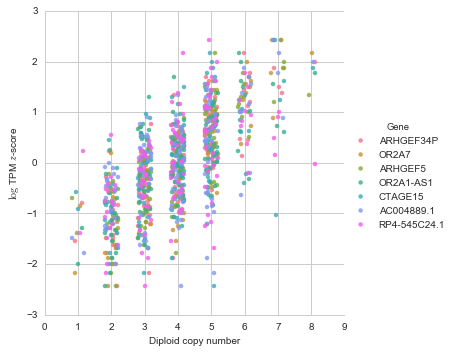

In [102]:
sns.lmplot(x='CNV_7_143951166_143953316', y='exp', data=data, hue='Gene',
           x_jitter=0.2, fit_reg=False)
plt.ylabel('$\log$ TPM $z$-score', fontsize=10)
plt.xlabel('Diploid copy number', fontsize=10)
plt.savefig(os.path.join(outdir, 'CNV_7_143951166_143953316_reg.pdf'))

In [32]:
%%R

suppressPackageStartupMessages(library(Gviz))
suppressPackageStartupMessages(library(GenomicFeatures))

In [83]:
chrom = 'chr7'
start = 143851293
end = 144061217
fontsize = 7
cnv_color = '#000000'
cepbp_color = "#20B2AA"
dnase_color = "#663399"
cnvs = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_cnvs.bed')

In [76]:
%%R -i data,chrom,start,end,fontsize,cepbp_color,dnase_color,cnv_color,cnvs

cnvTrack <- AnnotationTrack(
    range=cnvs, 
    genome="hg19",
    chromosome=chrom, 
    start=start, 
    end=end,
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="CNVs",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
    )

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=8, 
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="CS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

cebpbTrack <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsSydhH1hescCebpbIggrabUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="CEBPB",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=8,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

cnvTrack = setPar(cnvTrack, "fill", cnv_color)
cebpbTrack = setPar(cebpbTrack, "fill", cepbp_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

In [77]:
fn = os.path.join(outdir, 'CNV_7_143951166_143953316_region.pdf')

In [85]:
%%R -i fn,chrom,start,end

pdf(fn, 8, 3)
plotTracks(c(gtrack, biomTrack, cnvTrack, cebpbTrack, dnaseTrack, hmmTrack), chromosome=chrom, 
           from=start, to=end, col.title="black", sizes=c(0.22, 1, 0.12, 0.12, 0.12, 0.12))
dev.off()

png 
  2 


In [86]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [87]:
gene_info[gene_info.gene_name == 'CTAGE15']

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000176227.9,CTAGE15,pseudogene,chr7,143268818,143271478,+,KNOWN,ENSEMBL,3
ENSG00000271079.1,CTAGE15,protein_coding,chr7,143268893,143271480,+,KNOWN,HAVANA,2
